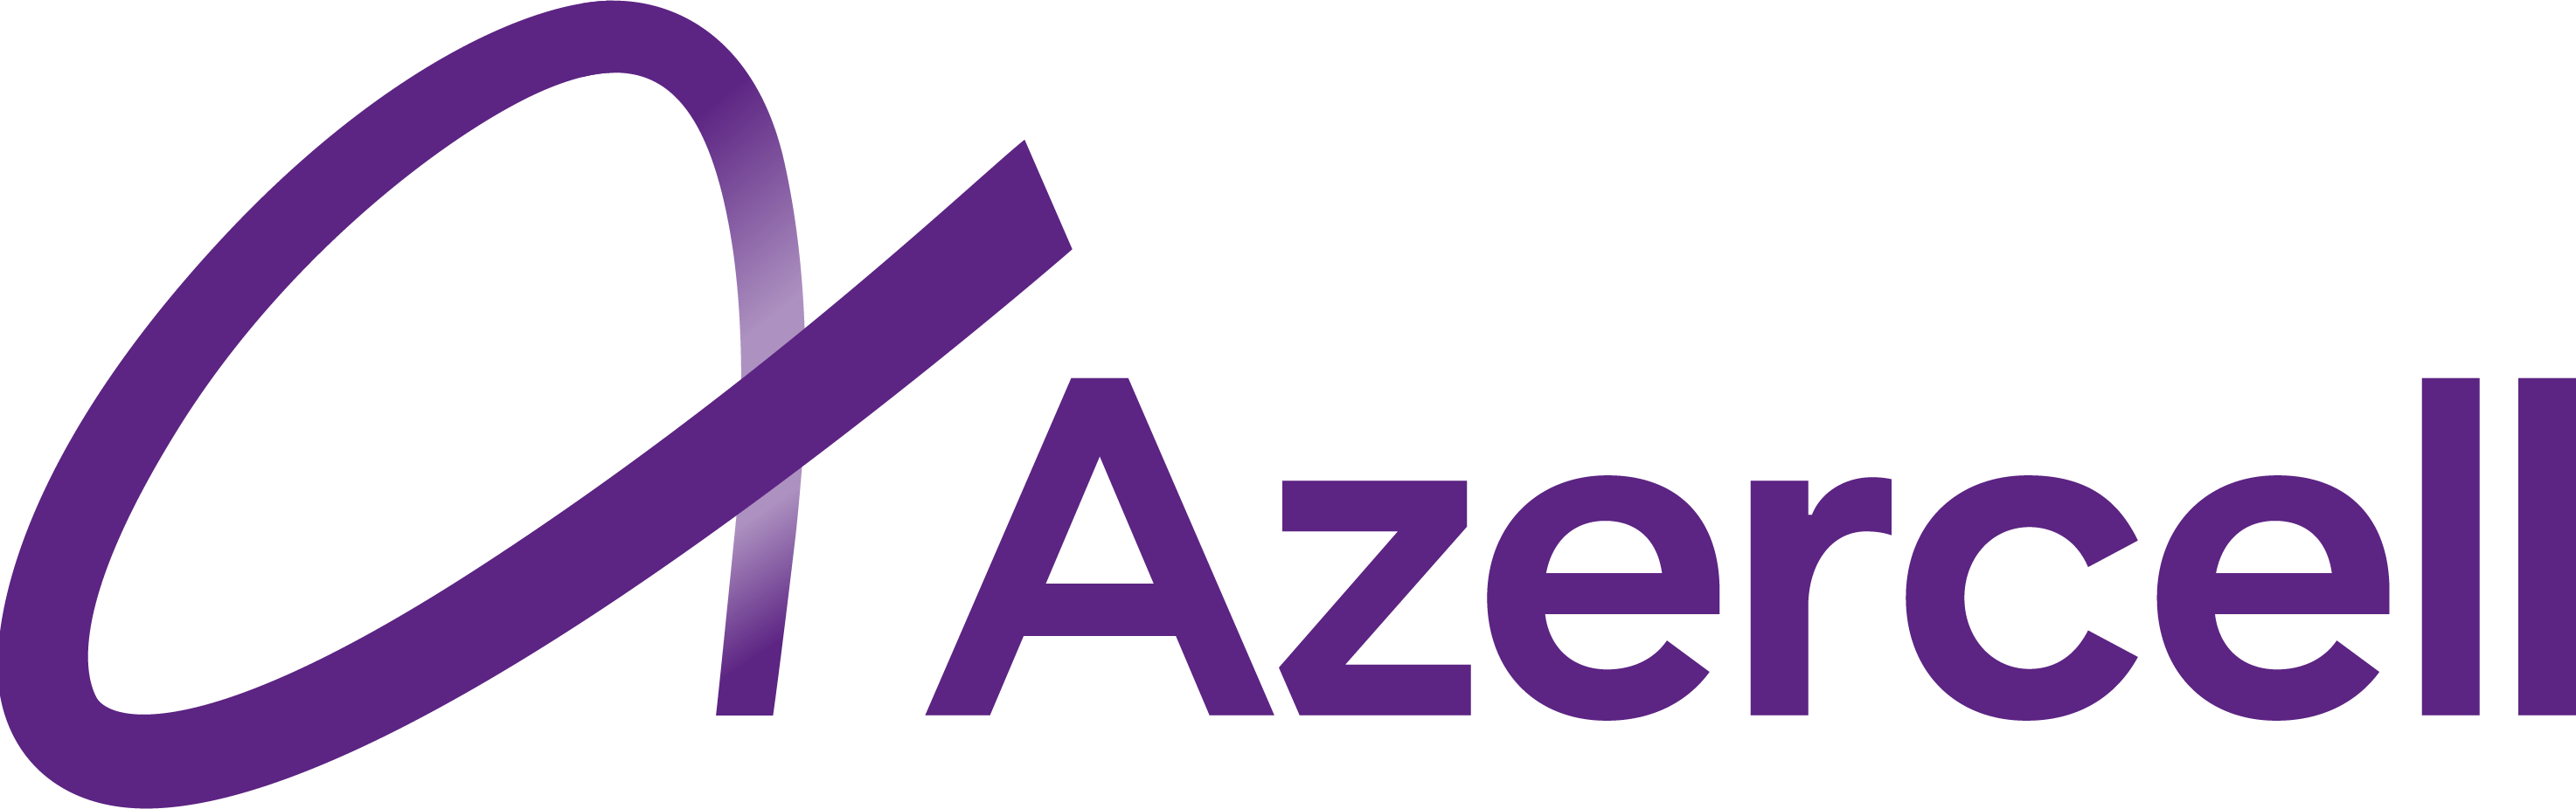

In [ ]:
# Libraries
import pandas as pd
import warnings as wg
from deep_translator import GoogleTranslator
from transformers import pipeline
import re
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from googletrans import Translator
import nltk
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')

In [ ]:
# Install Packages
!pip install deep_translator
!pip install translate
!pip install googletrans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Dataset
comments = pd.read_excel('/content/azercell_instagram_comments.xlsx')

## Məlumatın hazırlanması

In [ ]:
# İlk öncə sütun adlarını dəyişək
comments.columns = ['hesab_adı','rəy','post_tarix','post_saat','rəy_tarix','post_content','rəy_bəyənmə','post_bəyənmə','post_şəkil']

# Post-ların paylaşıldığı saat sütununu düzəldək
comments["post_saat"] = pd.to_datetime(comments["post_saat"]).dt.time

# Indi isə rəylərin bəyənmə sayını düzgün numerik məlumat tipinə gətirək
comments['rəy_bəyənmə'] = comments['rəy_bəyənmə'].apply(lambda x: str(x).split(' ')[0])

# Hər şey qaydasında görünür amma məlumat tiplərini də yoxlamaq lazımdır
comments.dtypes

# Numerik, text və tarix olan sütunları müvafiq tipə çevirək
for sutun in ['rəy_bəyənmə','post_bəyənmə']:
  comments[sutun] = comments[sutun].apply(lambda x: str(x).replace(',',''))
  comments[sutun] = comments[sutun].astype(int)

for sutun in ['post_tarix','rəy_tarix']:
  comments[sutun] = pd.to_datetime(comments[sutun])

for sutun in ['post_saat']:
  comments[sutun] = pd.to_datetime(comments[sutun], format='%H:%M:%S').dt.time

for sutun in ['hesab_adı','rəy','post_content','post_şəkil']:
  comments[sutun] = comments[sutun].astype(str)

## Deskriptiv analiz

In [ ]:
# Ümumi say haqqında:
print(f"""| İlkin analiz:
>Məlumat dəstində ümumi {comments.shape[0]}-sayda rəy var.
>Bunlar müvafiq olaraq, {comments[['post_tarix', 'post_saat']].drop_duplicates().shape[0]} sayda unique postdan çəkilmişdir.
>Verilmiş sample-da {comments['hesab_adı'].nunique()} sayda unique hesab var.
>Hesab başına {round(comments.shape[0]/comments['hesab_adı'].nunique(),2)} sayda rəy düşür.
>Toplam {comments['post_bəyənmə'].sum()} sayda bəyənmə sayı var.
⚠ Bu statistika yalnışdır:
>Hesab başına {round(comments['post_bəyənmə'].sum()/comments['hesab_adı'].nunique(),2)} sayda bəyənmə düşür.
| Çünki bizə bəyənmə qazandıran hesablar rəy yazmamış ola bilər.""")

| İlkin analiz:
>Məlumat dəstində ümumi 4942-sayda rəy var.
>Bunlar müvafiq olaraq, 483 sayda unique postdan çəkilmişdir.
>Verilmiş sample-da 3587 sayda unique hesab var.
>Hesab başına 1.38 sayda rəy düşür.
>Toplam 15464141 sayda bəyənmə sayı var.
⚠ Bu statistika yalnışdır:
>Hesab başına 4311.16 sayda bəyənmə düşür.
| Çünki bizə bəyənmə qazandıran hesablar rəy yazmamış ola bilər.


## Məlumatın tərcümə edilməsi

In [ ]:
translator = GoogleTranslator(source='az', target='en')
comments['rəy_eng'] = comments['rəy'].apply(lambda x: translator.translate(x))

unique_post_content = comments['post_content'].unique()
post_content_eng = dict()
for content in unique_post_content:
  post_content_eng[content] = translator.translate(content)

comments['post_content_eng'] = comments['post_content'].map(post_content_eng)

## Emoji işlənmə tezliyi

In [ ]:
def extract_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    return "".join(emoji_pattern.findall(text)) if isinstance(text, str) else ""

comments['emoji'] = comments['rəy'].apply(extract_emojis)

## Vətəndaş Rəylərinin Qruplaşdırılması

In [ ]:
# Rəyin qrupları: Questions / Complaint / Other / Praise

### Method 1: zero-shot-classification

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
candidate_labels = ["Question", "Complaint", "Praise", "Other"]

def comment_group(x):
    try:
        comment = x
        results = classifier(comment, candidate_labels)
        labels = results['labels']
        scores = results['scores']
        label_score_dict = dict(zip(labels, scores))
        praise = label_score_dict['Praise']
        other = label_score_dict['Other']
        question = label_score_dict['Question']
        complaint = label_score_dict['Complaint']
        return praise,other,question,complaint
    except Exception as e:
        return 0, 0, 0, 0

comments[['Tərif', 'Başqa', 'Sual', 'Şikayət']] = comments['rəy_eng'].apply(lambda x: pd.Series(comment_group(x)))

In [ ]:
columns_to_consider = ['Tərif', 'Başqa', 'Sual', 'Şikayət']

def get_max_column(row):
    return row[columns_to_consider].idxmax()

comments['rəyin_kateqoriyası_z_s_c'] = comments.apply(get_max_column, axis=1)

In [ ]:
comments[['Tərif_az', 'Başqa_az', 'Sual_az', 'Şikayət_az']] = comments['rəy'].apply(lambda x: pd.Series(comment_group(x)))

columns_to_consider = ['Tərif_az', 'Başqa_az', 'Sual_az', 'Şikayət_az']

comments['rəyin_kateqoriyası_z_s_c_az'] = comments.apply(get_max_column, axis=1)

#### Azərbaycan dili ilə müqayisə etdiyimizdə görürük ki ingilis dilinə nisbətən qeyri-dəqiqliklər çoxdur

In [ ]:
comments.head(4)

,hesab_adı,rəy,post_tarix,post_saat,rəy_tarix,post_content,rəy_bəyənmə,post_bəyənmə,post_şəkil,hesab_adı_clean,...,Tərif,Başqa,Sual,Şikayət,rəyin_kateqoriyası_z_s_c,Tərif_az,Başqa_az,Sual_az,Şikayət_az,rəyin_kateqoriyası_z_s_c_az
0,nabasova_,🙌,2022-01-27,07:00:11,2022-03-10,Texnologiya üzrə tapşırıqların ən uğurlu həll ...,0,476,https://instagram.fgyd20-2.fna.fbcdn.net/v/t51...,[],...,0.000000,0.000000,0.000000,0.000000,Tərif,0.259497,0.315855,0.243308,0.181340,Başqa_az
1,kananhadjizadeh,Salam mən ATU da oxuyuram təqaüd proqramına qa...,2022-01-27,07:00:11,2022-02-13,Texnologiya üzrə tapşırıqların ən uğurlu həll ...,0,476,https://instagram.fgyd20-2.fna.fbcdn.net/v/t51...,['kananhadjizadeh'],...,0.079238,0.083297,0.727759,0.109705,Sual,0.329294,0.026801,0.546601,0.097304,Sual_az
2,y.xaqani_,Salam. Hal-hazirda ishnen bagli vakansiyaniz v...,2022-01-27,07:00:11,2022-01-28,Texnologiya üzrə tapşırıqların ən uğurlu həll ...,0,476,https://instagram.fgyd20-2.fna.fbcdn.net/v/t51...,['y.xaqani'],...,0.046511,0.089700,0.770933,0.092856,Sual,0.412539,0.044024,0.472839,0.070598,Sual_az
3,m_usayeva_22,Salam gùnù 20 qepiy danwmaqi nece etmyi olar ...,2022-01-27,07:00:11,2022-01-28,Texnologiya üzrə tapşırıqların ən uğurlu həll ...,0,476,https://instagram.fgyd20-2.fna.fbcdn.net/v/t51...,['m_usayeva_22'],...,0.034640,0.061201,0.773349,0.130810,Sual,0.835996,0.051629,0.083926,0.028448,Tərif_az


In [ ]:
# Lazımsız sütunları götürməyək
comments = comments[['hesab_adı', 'rəy', 'post_tarix', 'post_saat', 'rəy_tarix',
       'post_content', 'rəy_bəyənmə', 'post_bəyənmə', 'post_şəkil', 'rəy_eng', 'post_content_eng',
       'emoji', 'Tərif','Başqa', 'Sual', 'Şikayət', 'rəyin_kateqoriyası_z_s_c']]

### Method 2: sentiment-analysis

In [ ]:
classifier_2 = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def comment_group_s_a(x):
    try:
        comment = str(x) if pd.notna(x) else ""
        results = classifier_2(comment)
        labels = results[0]['label']
        scores = results[0]['score']

        return labels, scores
    except Exception as e:
        return "", 0.0

comments[['labels_s_a', 'scores_s_a']] = comments['rəy_eng'].apply(lambda x: pd.Series(comment_group_s_a(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


### Method 3: text-classification

In [ ]:
classifier_3 = pipeline("text-classification", model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def comment_group_t_c(x):
    try:
        comment = str(x) if pd.notna(x) else ""
        results = classifier_3(comment)
        labels = results[0]['label']
        scores = results[0]['score']
        return labels,scores
    except Exception as e:
        return 0, 0

comments[['labels_t_c','scores_t_c']] = comments['rəy_eng'].apply(lambda x: pd.Series(comment_group_t_c(x)))

In [ ]:
comments.to_excel('sentiment.xlsx',index = False)

## Hesab Adlarında xüsusi isimlər

In [ ]:
def nltk_func(x):
    account_name = str(x)
    blob = TextBlob(account_name)
    keywords = blob.noun_phrases
    return keywords

hesab = pd.DataFrame(comments['hesab_adı'])
hesab['hesab_adı_clean'] = hesab['hesab_adı'].str.replace(r'[^a-zA-Z]', ' ', regex=True).str.strip()
hesab['hesab_adı_nltk'] = hesab['hesab_adı_clean'].apply(lambda x: nltk_func(str(x).capitalize()))

print(hesab[['hesab_adı', 'hesab_adı_clean', 'hesab_adı_nltk']].head())

         hesab_adı  hesab_adı_clean     hesab_adı_nltk
0        nabasova_         nabasova         [nabasova]
1  kananhadjizadeh  kananhadjizadeh  [kananhadjizadeh]
2        y.xaqani_         y xaqani                 []
3     m_usayeva_22        m usayeva        [m usayeva]
4       perviz7321           perviz           [perviz]


## Hesablar üzrə Segmentləşmə

In [ ]:
# Analiz üçün lazım olan sütunları saxlayırıq
comments = comments[comments['labels_s_a'] != '']
segment_user = comments[['hesab_adı', 'rəy_tarix', 'rəy_bəyənmə', 'post_bəyənmə', 'Tərif',
        'Başqa', 'Sual', 'Şikayət', 'labels_s_a', 'scores_s_a', 'labels_t_c', 'scores_t_c']]

In [ ]:
# Feature engineering edirik
def func(x):
    year = x.year
    return (1, 0, 0, 0) if year == 2021 else (0, 1, 0, 0) if year == 2022 else (0, 0, 1, 0) if year == 2023 else (0, 0, 0, 1) if year == 2024 else (0, 0, 0, 0)

segment_user[['c_2021', 'c_2022', 'c_2023', 'c_2024']] = segment_user['rəy_tarix'].apply(lambda x: pd.Series(func(x)))
segment_user['labels_s_a'] = segment_user['labels_s_a'].apply(lambda x: int(str(x).split(' ')[0]))

In [ ]:
segment_user = segment_user.groupby('hesab_adı').agg(
    rəy_bəyənmə_min = ('rəy_bəyənmə', 'min'),
    rəy_bəyənmə_max = ('rəy_bəyənmə', 'max'),
    rəy_bəyənmə_avg = ('rəy_bəyənmə', 'mean'),
    post_bəyənmə_avg = ('post_bəyənmə', 'mean'),
    tərif_min = ('Tərif', 'min'),
    tərif_max = ('Tərif', 'max'),
    tərif_avg = ('Tərif', 'mean'),
    başqa_min = ('Başqa', 'min'),
    başqa_max = ('Başqa', 'max'),
    başqa_avg = ('Başqa', 'mean'),
    sual_min = ('Sual', 'min'),
    sual_max = ('Sual', 'max'),
    sual_avg = ('Sual', 'mean'),
    şikayət_min = ('Şikayət', 'min'),
    şikayət_max = ('Şikayət', 'max'),
    şikayət_avg = ('Şikayət', 'mean'),
    labels_s_a_min = ('labels_s_a', 'min'),
    labels_s_a_max = ('labels_s_a', 'max'),
    labels_s_a_avg = ('labels_s_a', 'mean'),
    c_2021 = ('c_2021', 'max'),
    c_2022 = ('c_2022', 'max'),
    c_2023 = ('c_2023', 'max'),
    c_2024 = ('c_2024', 'max')
).reset_index()

In [ ]:
columns_for_clustering = ['rəy_bəyənmə_min', 'rəy_bəyənmə_max', 'rəy_bəyənmə_avg',
       'post_bəyənmə_avg', 'tərif_min', 'tərif_max', 'tərif_avg', 'başqa_min',
       'başqa_max', 'başqa_avg', 'sual_min', 'sual_max', 'sual_avg',
       'şikayət_min', 'şikayət_max', 'şikayət_avg', 'labels_s_a_min',
       'labels_s_a_max', 'labels_s_a_avg', 'c_2021', 'c_2022', 'c_2023',
       'c_2024']

X = segment_user[columns_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
segment_user['cluster'] = kmeans.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, segment_user['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.20838544553238644


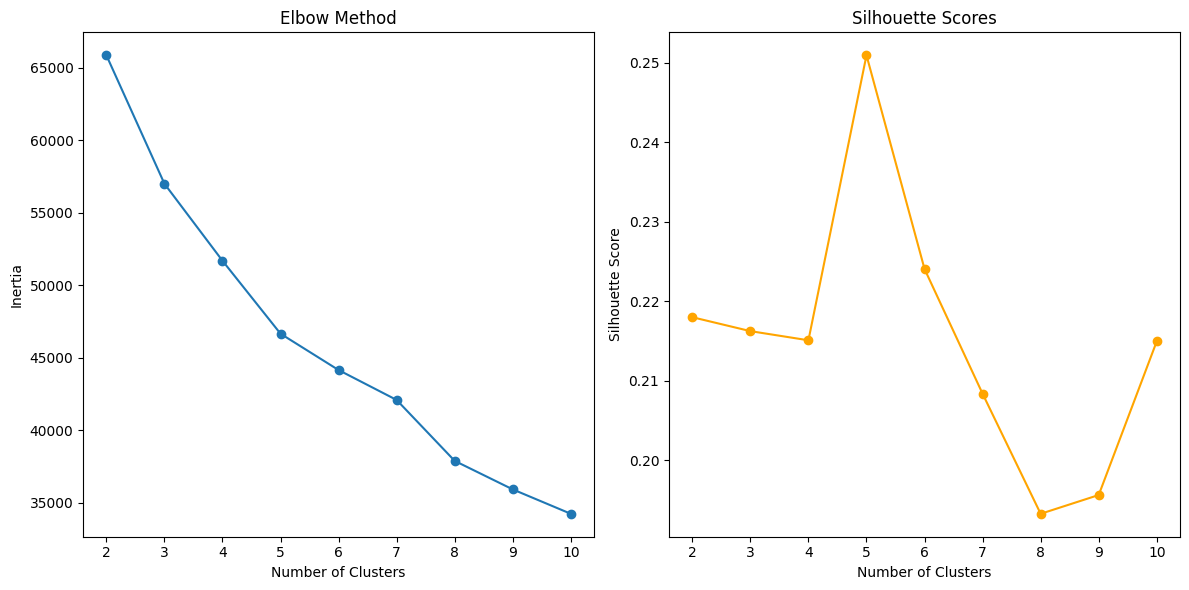

In [ ]:
columns_for_clustering = ['rəy_bəyənmə_min', 'rəy_bəyənmə_max', 'rəy_bəyənmə_avg',
       'post_bəyənmə_avg', 'tərif_min', 'tərif_max', 'tərif_avg', 'başqa_min',
       'başqa_max', 'başqa_avg', 'sual_min', 'sual_max', 'sual_avg',
       'şikayət_min', 'şikayət_max', 'şikayət_avg', 'labels_s_a_min',
       'labels_s_a_max', 'labels_s_a_avg', 'c_2021', 'c_2022', 'c_2023',
       'c_2024']

X = segment_user[columns_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)

    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

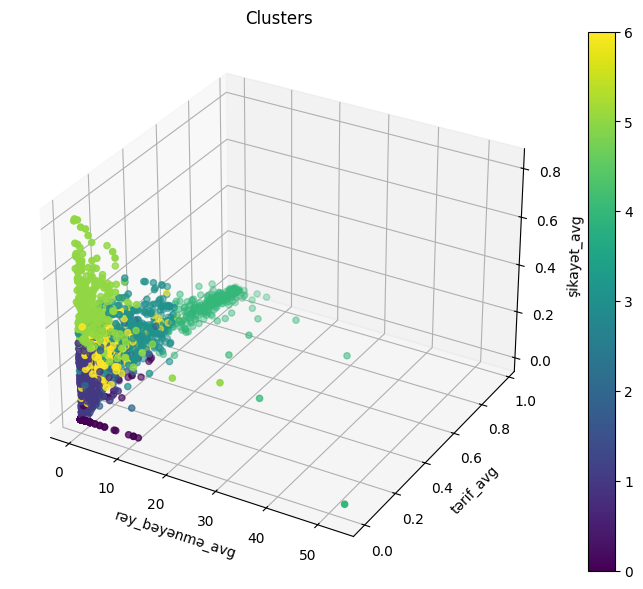

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(segment_user['rəy_bəyənmə_avg'], segment_user['tərif_avg'], segment_user['şikayət_avg'], c=segment_user['cluster'], cmap='viridis')

ax.set_xlabel('rəy_bəyənmə_avg')
ax.set_ylabel('tərif_avg')
ax.set_zlabel('şikayət_avg')
ax.set_title('Clusters')

plt.colorbar(scatter)

plt.show()

In [ ]:
fig = px.scatter_3d(segment_user,
                    x='rəy_bəyənmə_avg',
                    y='tərif_avg',
                    z='şikayət_avg',
                    color='cluster',
                    color_continuous_scale='viridis',
                    title='Clusters in 3D')

fig.show()

In [ ]:
segment_user.to_excel('segment.xlsx',index =False)

## Ngrid

In [ ]:
# N-gramların hazırlanması
df = comments.copy()

translator = Translator()

def preprocess(text):
    text = str(text)
    tokens = word_tokenize(text.lower())
    filtered_tokens = [
        word for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    return filtered_tokens

def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Preprocess and create n-grams
df['tokens'] = df['rəy_eng'].apply(preprocess)
df['1-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 1))
df['2-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 2))
df['3-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 3))
df['4-grams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 4))

# Combine all n-grams in the dataset
all_1grams = [item for sublist in df['1-grams'] for item in sublist]
all_2grams = [item for sublist in df['2-grams'] for item in sublist]
all_3grams = [item for sublist in df['3-grams'] for item in sublist]
all_4grams = [item for sublist in df['4-grams'] for item in sublist]

def count_ngrams(ngrams_list):
    return Counter(ngrams_list)

# Count frequencies
all_1grams_counter = count_ngrams(all_1grams)
all_2grams_counter = count_ngrams(all_2grams)
all_3grams_counter = count_ngrams(all_3grams)
all_4grams_counter = count_ngrams(all_4grams)

def calculate_probabilities(ngrams_counter):
    total_ngrams = sum(ngrams_counter.values())
    probabilities = {ngram: count / total_ngrams for ngram, count in ngrams_counter.items()}
    return probabilities

# Calculate probabilities
prob_1grams = calculate_probabilities(all_1grams_counter)
prob_2grams = calculate_probabilities(all_2grams_counter)
prob_3grams = calculate_probabilities(all_3grams_counter)
prob_4grams = calculate_probabilities(all_4grams_counter)

# Create DataFrames for unique n-grams with their frequencies and probabilities
df_1grams = pd.DataFrame.from_dict(all_1grams_counter, orient='index', columns=['1Frequency'])
df_1grams['1Probability'] = df_1grams.index.map(prob_1grams)
df_1grams.index = [' '.join(gram) for gram in df_1grams.index]

df_2grams = pd.DataFrame.from_dict(all_2grams_counter, orient='index', columns=['2Frequency'])
df_2grams['2Probability'] = df_2grams.index.map(prob_2grams)
df_2grams.index = [' '.join(gram) for gram in df_2grams.index]

df_3grams = pd.DataFrame.from_dict(all_3grams_counter, orient='index', columns=['3Frequency'])
df_3grams['3Probability'] = df_3grams.index.map(prob_3grams)
df_3grams.index = [' '.join(gram) for gram in df_3grams.index]

df_4grams = pd.DataFrame.from_dict(all_4grams_counter, orient='index', columns=['4Frequency'])
df_4grams['4Probability'] = df_4grams.index.map(prob_4grams)
df_4grams.index = [' '.join(gram) for gram in df_4grams.index]

df_1grams = df_1grams.reset_index().rename(columns={'index': '1N-gram'})
df_2grams = df_2grams.reset_index().rename(columns={'index': '2N-gram'})
df_3grams = df_3grams.reset_index().rename(columns={'index': '3N-gram'})
df_4grams = df_4grams.reset_index().rename(columns={'index': '4N-gram'})

df_1grams = df_1grams.sort_values(by = ['1Frequency'], ascending = False).reset_index().head(50)
df_2grams = df_2grams.sort_values(by = ['2Frequency'], ascending = False).reset_index().head(50)
df_3grams = df_3grams.sort_values(by = ['3Frequency'], ascending = False).reset_index().head(50)
df_4grams = df_4grams.sort_values(by = ['4Frequency'], ascending = False).reset_index().head(50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Emoji işlənmə tezliyi

In [ ]:
percentage = (comments['emoji'].count() / comments.shape[0]) * 100
print(f"Emoji ilə olan rəylərin toplam rəy sayına nisbəti: {percentage:.2f}%")

Emoji ilə olan rəylərin toplam rəy sayına nisbəti: 21.64%


In [ ]:
emoji = comments[~pd.isna(comments['emoji'])]
emoji

In [ ]:
emoji_sentiment_mapping = {
    'Positive': [
        '🎊', '🙌', '🔥', '🧨', '🤩', '💐', '🎸', '♥', '💓', '😄', '💗',
        '🎈', '🌺', '😁', '👌', '🍀', '🍂', '🤤', '😍', '💫', '✨', '🫶',
        '✔', '🥋', '🎁', '🎆', '🧡', '🤯', '❤', '🎉', '😀', '👬', '🌹',
        '🙂', '🥰', '🤗', '💚', '👋', '💃', '🤣', '😎', '💯', '🚀', '✅',
        '💞', '💖', '🦄', '💜', '💘', '💵', '💙', '🥳'
    ],
    'Negative': [
        '😞', '👎', '😡', '🤧', '😒', '🥀', '💔', '😱', '😢', '💔', '😭',
        '😓', '😔', '😰', '😱', '😑', '😐', '😆', '🤢', '🤮', '🥲', '😿',
        '💥', '❌', '👿', '😕', '😤', '⚠️', '😣', '🙄', '⚡', '🥴', '😴'
    ],
    'Neutral': [
        '👅', '😮', '🏐', '🙃', '𝑨', '𝗿', '🖨', '𝒎', '🏾', '🇱', '🫡',
        '🖖', '𝚆', '𝙽', '𝚕', '𝗲', '🛼', '👈', '𝗸', '𝙷', '📍', '📤',
        '⠀', '☝', '🌾', '🏞', '𝒓', '𝐍', '⤵', '🧑', '🏽', '𝚍', '𝒊',
        '𝙸', '📝', '🇷', '🏃', '💂', '🖤', '🔷', '🛑', '🏘', '📱', '📝',
        '😐', '🧾', '🎇', '💫', '💪', '💚', '💰', '📉', '🖐', '📩', '💼',
        '🚗', '📃', '💸', '📝', '📲', '📊', '📝', '📚', '✍', '📒', '✏',
        '🍁', '📝', '🌸', '📌', '📦', '🏀', '📍', '📞', '📝', '🏆', '⬆',
        '🏞', '📱', '🗓', '🛋', '🎸', '⚽', '⏳', '🍃', '📑', '🦾'
    ]
}


def get_sentiment_for_emoji(emoji):
    for sentiment, emojis in emoji_sentiment_mapping.items():
        if emoji in emojis:
            return sentiment
    return 'Neutral'

emoji['emoji_sentiment'] = emoji['emoji'].apply(lambda x: get_sentiment_for_emoji(x))

In [ ]:
emoji['emoji_sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)